# PBDL Oslo PM2.5

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from scipy.stats import randint as sp_randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

# Load data
df = pd.read_excel("PM25OsloTS.xlsx")

# Temporal feature processing
df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%Y')
df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df = df.sort_values(by='Time')

# Extract features and target variable
X = df[["TV", "Tmean", "HDD", "VP", "WS", "WG", "meanRH", "SD", "PP", "Year", "Month","Day"]]
y = df["PM25"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define ODE function
def ode_function(TV, Tmean, HDD, VP, WS, WG, meanRH, SD, PP):
    pass

# Custom layer to incorporate ODE function
class ODELayer(tf.keras.layers.Layer):
    def __init__(self, ode_function, **kwargs):
        super(ODELayer, self).__init__(**kwargs)
        self.ode_function = ode_function

    def call(self, inputs):
        # Apply the ODE function
        return self.ode_function(*inputs)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]  # Output shape same as input shape except the last dimension  

# Define physical-based loss function with L2 regularization
def ode_system(y_true, y_pred):
    # Your implementation of ode_system with L2 regularization
    loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Example: Mean Squared Error
    return loss

# Define custom estimator class
class CustomEstimator(BaseEstimator):
    def __init__(self, learning_rate, num_units, num_layers, kernel_regularizer=None):
        self.learning_rate = learning_rate
        self.num_units = num_units
        self.num_layers = num_layers
        self.kernel_regularizer = kernel_regularizer

        
    def fit(self, X, y):
        model = Sequential()
        model.add(Dense(units=self.num_units, kernel_initializer="he_normal", input_shape=(12,), kernel_regularizer=self.kernel_regularizer))
        model.add(BatchNormalization())
        model.add(Activation("elu"))
        for _ in range(self.num_layers - 1):
            model.add(Dense(units=self.num_units, kernel_initializer="he_normal", kernel_regularizer=self.kernel_regularizer))
            model.add(BatchNormalization())
            model.add(Activation("elu"))
        model.add(Dense(units=1))
        optimizer = tf.keras.optimizers.Nadam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss=ode_system, metrics=['mse'])
        self.model = model
        self.history = self.model.fit(X, y, epochs=1000, batch_size=32, verbose=0)
        return self

# Define hyperparameters for random search
param_dist = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'num_units': sp_randint(50, 200),
    'num_layers': sp_randint(1, 4),
    'kernel_regularizer': [None, l2(0.01), l2(0.001)]
}

# Create an instance of CustomEstimator
custom_estimator_instance = CustomEstimator(learning_rate=0.001, num_units=100, num_layers=2)

# Define custom scorer
def custom_scorer(estimator, X, y):
    return -estimator.model.evaluate(X, y, verbose=0)[0]  # Return negative validation loss

# Create and fit RandomizedSearchCV with the instance of CustomEstimator
random_search = RandomizedSearchCV(estimator=custom_estimator_instance, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, scoring=custom_scorer)
random_search_result = random_search.fit(X_train, y_train)
 
# Print best parameters and best score
print("Best Parameters: ", random_search_result.best_params_)
print("Best Score: ", random_search_result.best_score_)

# Access the best model from the RandomizedSearchCV
best_model = random_search.best_estimator_.model

# Train the model with best parameters
history = best_model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=1)


  

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\congc\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END kernel_regularizer=<keras.src.regularizers.regularizers.L2 object at 0x000002192B5AC1D0>, learning_rate=0.005, num_layers=1, num_units=64; total time= 1.9min
[CV] END kernel_regularizer=<keras.src.regularizers.regularizers.L2 object at 0x000002192B5AC1D0>, learning_rate=0.005, num_layers=1, num_units=64; total time= 1.7min
[CV] END kernel_regularizer=<keras.src.regularizers.regularizers.L2 object at 0x000002192B5AC1D0>, learning_rate=0.005, num_layers=1, num_units=64; total time= 3.5min
[CV] END kernel_regularizer=<keras.src.regularizers.regularizers.L2 object at 0x000002192B5AC1D0>, learning_rate=0.01, num_layers=1, num_units=152; total time= 1.8min
[CV] END kernel_regularizer=<keras.src.regularizers.regularizers.L2 object at 0x000002192B5AC1D0>, learning_rate=0.01, num_layers=1, num_units=152; total time= 3.7min
[CV] END kernel_regularizer=<keras.src.regularizers.regularizers.L2 object at 0x000002192B5AC1D0>, learning_rate=0.01, num_layers=1, num_units=152; total time= 2.2mi

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1087 - mse: 1.0915 - val_loss: 1.2028 - val_mse: 1.1786
Epoch 24/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1267 - mse: 1.1090 - val_loss: 1.2087 - val_mse: 1.1733
Epoch 25/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0470 - mse: 1.0224 - val_loss: 1.2482 - val_mse: 1.2168
Epoch 26/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8765 - mse: 0.8566 - val_loss: 1.2520 - val_mse: 1.2214
Epoch 27/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9754 - mse: 0.9534 - val_loss: 1.2309 - val_mse: 1.2021
Epoch 28/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1189 - mse: 1.1011 - val_loss: 1.2263 - val_mse: 1.1968
Epoch 29/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0257 - mse: 1.0070 - val_loss: 1.2191 - val_mse: 1.1905
Epoch 30/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0349 - mse: 1.0177 - val_loss: 1.2466 - val_mse: 1.2175
Epoch 31/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0249 - mse: 1.0076 - val_loss: 1.2326 - val_mse: 1.2004
Epoch 77/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2107 - mse: 1.1907 - val_loss: 1.2426 - val_mse: 1.2127
Epoch 78/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3008 - mse: 1.2790 - val_loss: 1.2238 - val_mse: 1.1945
Epoch 79/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9178 - mse: 0.8972 - val_loss: 1.2280 - val_mse: 1.1983
Epoch 80/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0862 - mse: 1.0673 - val_loss: 1.2231 - val_mse: 1.1913
Epoch 81/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9603 - mse: 0.9432 - val_loss: 1.2128 - val_mse: 1.1867
Epoch 82/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8487 - mse: 0.8329 - val_loss: 1.2145 - val_mse: 1.1872
Epoch 83/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0435 - mse: 1.0264 - val_loss: 1.2379 - val_mse: 1.2063
Epoch 84/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0072 - mse: 0.9884 - val_loss: 1.2057 - val_mse: 1.1798
Epoch 130/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0125 - mse: 0.9976 - val_loss: 1.2045 - val_mse: 1.1806
Epoch 131/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9504 - mse: 0.9347 - val_loss: 1.3296 - val_mse: 1.2938
Epoch 132/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1313 - mse: 1.1042 - val_loss: 1.2193 - val_mse: 1.1870
Epoch 133/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9083 - mse: 0.8845 - val_loss: 1.2342 - val_mse: 1.1991
Epoch 134/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0465 - mse: 1.0259 - val_loss: 1.2249 - val_mse: 1.1996
Epoch 135/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8574 - mse: 0.8403 - val_loss: 1.2137 - val_mse: 1.1861
Epoch 136/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9804 - mse: 0.9633 - val_loss: 1.2318 - val_mse: 1.2024
Epoch 137/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9885 - mse: 0.9709 - val_loss: 1.2155 - val_mse: 1.1868
Epoch 183/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9694 - mse: 0.9515 - val_loss: 1.2131 - val_mse: 1.1865
Epoch 184/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1438 - mse: 1.1270 - val_loss: 1.2048 - val_mse: 1.1797
Epoch 185/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0885 - mse: 1.0734 - val_loss: 1.2002 - val_mse: 1.1753
Epoch 186/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9227 - mse: 0.9081 - val_loss: 1.2131 - val_mse: 1.1834
Epoch 187/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1020 - mse: 1.0849 - val_loss: 1.2233 - val_mse: 1.1989
Epoch 188/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9091 - mse: 0.8926 - val_loss: 1.2123 - val_mse: 1.1879
Epoch 189/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1302 - mse: 1.1148 - val_loss: 1.2927 - val_mse: 1.2657
Epoch 190/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0029 - mse: 0.9880 - val_loss: 1.2290 - val_mse: 1.1951
Epoch 236/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9626 - mse: 0.9418 - val_loss: 1.2298 - val_mse: 1.2037
Epoch 237/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2472 - mse: 1.2313 - val_loss: 1.2269 - val_mse: 1.1984
Epoch 238/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9228 - mse: 0.9067 - val_loss: 1.2198 - val_mse: 1.1960
Epoch 239/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0259 - mse: 1.0095 - val_loss: 1.2377 - val_mse: 1.2106
Epoch 240/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9884 - mse: 0.9711 - val_loss: 1.2374 - val_mse: 1.2038
Epoch 241/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0875 - mse: 1.0678 - val_loss: 1.2138 - val_mse: 1.1891
Epoch 242/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1519 - mse: 1.1365 - val_loss: 1.2116 - val_mse: 1.1862
Epoch 243/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0620 - mse: 1.0448 - val_loss: 1.2244 - val_mse: 1.1990
Epoch 289/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2662 - mse: 1.2502 - val_loss: 1.2200 - val_mse: 1.1926
Epoch 290/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0377 - mse: 1.0182 - val_loss: 1.2383 - val_mse: 1.2018
Epoch 291/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0017 - mse: 0.9801 - val_loss: 1.2228 - val_mse: 1.1906
Epoch 292/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0434 - mse: 1.0241 - val_loss: 1.2223 - val_mse: 1.1939
Epoch 293/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0057 - mse: 0.9877 - val_loss: 1.2212 - val_mse: 1.1913
Epoch 294/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9374 - mse: 0.9165 - val_loss: 1.2050 - val_mse: 1.1782
Epoch 295/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1101 - mse: 1.0910 - val_loss: 1.2141 - val_mse: 1.1899
Epoch 296/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1428 - mse: 1.1279 - val_loss: 1.2260 - val_mse: 1.2001
Epoch 342/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1253 - mse: 1.1061 - val_loss: 1.2751 - val_mse: 1.2402
Epoch 343/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2629 - mse: 1.2394 - val_loss: 1.2343 - val_mse: 1.2031
Epoch 344/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9404 - mse: 0.9221 - val_loss: 1.2097 - val_mse: 1.1850
Epoch 345/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0538 - mse: 1.0387 - val_loss: 1.2298 - val_mse: 1.2061
Epoch 346/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9204 - mse: 0.9051 - val_loss: 1.2251 - val_mse: 1.1952
Epoch 347/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1147 - mse: 1.0954 - val_loss: 1.2120 - val_mse: 1.1836
Epoch 348/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0644 - mse: 1.0479 - val_loss: 1.2485 - val_mse: 1.2186
Epoch 349/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9885 - mse: 0.9654 - val_loss: 1.2435 - val_mse: 1.2059
Epoch 395/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2812 - mse: 1.2570 - val_loss: 1.2614 - val_mse: 1.2280
Epoch 396/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9778 - mse: 0.9578 - val_loss: 1.2111 - val_mse: 1.1845
Epoch 397/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1029 - mse: 1.0849 - val_loss: 1.2043 - val_mse: 1.1784
Epoch 398/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1065 - mse: 1.0898 - val_loss: 1.2189 - val_mse: 1.1932
Epoch 399/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0621 - mse: 1.0469 - val_loss: 1.2128 - val_mse: 1.1831
Epoch 400/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1141 - mse: 1.0971 - val_loss: 1.2192 - val_mse: 1.1935
Epoch 401/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0926 - mse: 1.0760 - val_loss: 1.2291 - val_mse: 1.2030
Epoch 402/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0014 - mse: 0.9842 - val_loss: 1.2137 - val_mse: 1.1838
Epoch 448/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0196 - mse: 1.0026 - val_loss: 1.2323 - val_mse: 1.2043
Epoch 449/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9372 - mse: 0.9190 - val_loss: 1.2244 - val_mse: 1.1998
Epoch 450/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2246 - mse: 1.2099 - val_loss: 1.2139 - val_mse: 1.1889
Epoch 451/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0670 - mse: 1.0509 - val_loss: 1.2119 - val_mse: 1.1875
Epoch 452/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0766 - mse: 1.0610 - val_loss: 1.2071 - val_mse: 1.1798
Epoch 453/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0672 - mse: 1.0511 - val_loss: 1.2495 - val_mse: 1.2206
Epoch 454/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1451 - mse: 1.1288 - val_loss: 1.2091 - val_mse: 1.1861
Epoch 455/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0541 - mse: 1.0346 - val_loss: 1.2389 - val_mse: 1.2064
Epoch 501/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1858 - mse: 1.1633 - val_loss: 1.2520 - val_mse: 1.2228
Epoch 502/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0078 - mse: 0.9904 - val_loss: 1.2191 - val_mse: 1.1916
Epoch 503/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1236 - mse: 1.1053 - val_loss: 1.2125 - val_mse: 1.1840
Epoch 504/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0106 - mse: 0.9934 - val_loss: 1.2104 - val_mse: 1.1817
Epoch 505/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0760 - mse: 1.0583 - val_loss: 1.2292 - val_mse: 1.2038
Epoch 506/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8657 - mse: 0.8488 - val_loss: 1.2174 - val_mse: 1.1861
Epoch 507/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9868 - mse: 0.9675 - val_loss: 1.2902 - val_mse: 1.2548
Epoch 508/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0474 - mse: 1.0308 - val_loss: 1.2179 - val_mse: 1.1933
Epoch 554/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0500 - mse: 1.0356 - val_loss: 1.2253 - val_mse: 1.1950
Epoch 555/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9082 - mse: 0.8897 - val_loss: 1.2156 - val_mse: 1.1890
Epoch 556/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1072 - mse: 1.0889 - val_loss: 1.2566 - val_mse: 1.2256
Epoch 557/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1214 - mse: 1.1022 - val_loss: 1.1974 - val_mse: 1.1703
Epoch 558/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9773 - mse: 0.9569 - val_loss: 1.2087 - val_mse: 1.1790
Epoch 559/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0278 - mse: 1.0113 - val_loss: 1.2487 - val_mse: 1.2184
Epoch 560/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9801 - mse: 0.9606 - val_loss: 1.2399 - val_mse: 1.2116
Epoch 561/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8707 - mse: 0.8520 - val_loss: 1.3297 - val_mse: 1.2968
Epoch 607/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1900 - mse: 1.1679 - val_loss: 1.2266 - val_mse: 1.2006
Epoch 608/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9915 - mse: 0.9753 - val_loss: 1.2201 - val_mse: 1.1925
Epoch 609/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0075 - mse: 0.9886 - val_loss: 1.2134 - val_mse: 1.1859
Epoch 610/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9656 - mse: 0.9499 - val_loss: 1.2138 - val_mse: 1.1897
Epoch 611/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0685 - mse: 1.0536 - val_loss: 1.2109 - val_mse: 1.1867
Epoch 612/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0768 - mse: 1.0619 - val_loss: 1.2291 - val_mse: 1.2025
Epoch 613/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9759 - mse: 0.9592 - val_loss: 1.2174 - val_mse: 1.1855
Epoch 614/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1653 - mse: 1.1509 - val_loss: 1.2230 - val_mse: 1.1998
Epoch 660/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0421 - mse: 1.0276 - val_loss: 1.2168 - val_mse: 1.1888
Epoch 661/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1015 - mse: 1.0843 - val_loss: 1.2109 - val_mse: 1.1858
Epoch 662/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9684 - mse: 0.9530 - val_loss: 1.2213 - val_mse: 1.1889
Epoch 663/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1561 - mse: 1.1378 - val_loss: 1.2052 - val_mse: 1.1770
Epoch 664/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1895 - mse: 1.1727 - val_loss: 1.2170 - val_mse: 1.1868
Epoch 665/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8816 - mse: 0.8641 - val_loss: 1.1993 - val_mse: 1.1751
Epoch 666/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9799 - mse: 0.9639 - val_loss: 1.2129 - val_mse: 1.1844
Epoch 667/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2446 - mse: 1.2251 - val_loss: 1.2131 - val_mse: 1.1874
Epoch 713/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0488 - mse: 1.0294 - val_loss: 1.2119 - val_mse: 1.1813
Epoch 714/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8227 - mse: 0.8024 - val_loss: 1.2164 - val_mse: 1.1877
Epoch 715/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0689 - mse: 1.0513 - val_loss: 1.2015 - val_mse: 1.1752
Epoch 716/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0831 - mse: 1.0669 - val_loss: 1.1950 - val_mse: 1.1714
Epoch 717/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9442 - mse: 0.9307 - val_loss: 1.2326 - val_mse: 1.2088
Epoch 718/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0567 - mse: 1.0401 - val_loss: 1.2146 - val_mse: 1.1892
Epoch 719/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0938 - mse: 1.0777 - val_loss: 1.2482 - val_mse: 1.2026
Epoch 720/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9809 - mse: 0.9652 - val_loss: 1.2156 - val_mse: 1.1897
Epoch 766/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9540 - mse: 0.9387 - val_loss: 1.2141 - val_mse: 1.1873
Epoch 767/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0123 - mse: 0.9966 - val_loss: 1.2509 - val_mse: 1.2201
Epoch 768/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0651 - mse: 1.0472 - val_loss: 1.2374 - val_mse: 1.2112
Epoch 769/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1013 - mse: 1.0843 - val_loss: 1.2246 - val_mse: 1.1974
Epoch 770/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9841 - mse: 0.9691 - val_loss: 1.2137 - val_mse: 1.1902
Epoch 771/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0317 - mse: 1.0144 - val_loss: 1.2128 - val_mse: 1.1877
Epoch 772/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1552 - mse: 1.1370 - val_loss: 1.2174 - val_mse: 1.1867
Epoch 773/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9081 - mse: 0.8908 - val_loss: 1.2267 - val_mse: 1.2006
Epoch 819/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0401 - mse: 1.0229 - val_loss: 1.2243 - val_mse: 1.1931
Epoch 820/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0783 - mse: 1.0576 - val_loss: 1.2412 - val_mse: 1.2099
Epoch 821/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9068 - mse: 0.8879 - val_loss: 1.2385 - val_mse: 1.2124
Epoch 822/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0762 - mse: 1.0586 - val_loss: 1.3254 - val_mse: 1.2958
Epoch 823/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0756 - mse: 1.0561 - val_loss: 1.2250 - val_mse: 1.1966
Epoch 824/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1655 - mse: 1.1462 - val_loss: 1.2042 - val_mse: 1.1777
Epoch 825/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0242 - mse: 1.0077 - val_loss: 1.2175 - val_mse: 1.1914
Epoch 826/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0295 - mse: 1.0107 - val_loss: 1.1979 - val_mse: 1.1696
Epoch 872/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9806 - mse: 0.9607 - val_loss: 1.2221 - val_mse: 1.1946
Epoch 873/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0350 - mse: 1.0145 - val_loss: 1.2576 - val_mse: 1.2306
Epoch 874/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0356 - mse: 1.0190 - val_loss: 1.2366 - val_mse: 1.2111
Epoch 875/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9037 - mse: 0.8868 - val_loss: 1.2253 - val_mse: 1.1984
Epoch 876/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0551 - mse: 1.0373 - val_loss: 1.2471 - val_mse: 1.2140
Epoch 877/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0463 - mse: 1.0241 - val_loss: 1.2130 - val_mse: 1.1855
Epoch 878/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9995 - mse: 0.9825 - val_loss: 1.2373 - val_mse: 1.2093
Epoch 879/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0809 - mse: 1.0654 - val_loss: 1.2128 - val_mse: 1.1883
Epoch 925/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9035 - mse: 0.8891 - val_loss: 1.2274 - val_mse: 1.2014
Epoch 926/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9782 - mse: 0.9601 - val_loss: 1.2045 - val_mse: 1.1766
Epoch 927/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9668 - mse: 0.9461 - val_loss: 1.2158 - val_mse: 1.1882
Epoch 928/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8722 - mse: 0.8559 - val_loss: 1.2231 - val_mse: 1.1968
Epoch 929/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8714 - mse: 0.8562 - val_loss: 1.3681 - val_mse: 1.3378
Epoch 930/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0469 - mse: 1.0279 - val_loss: 1.2524 - val_mse: 1.2241
Epoch 931/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9580 - mse: 0.9383 - val_loss: 1.2222 - val_mse: 1.1980
Epoch 932/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0509 - mse: 1.0376 - val_loss: 1.2242 - val_mse: 1.2002
Epoch 978/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8595 - mse: 0.8458 - val_loss: 1.2291 - val_mse: 1.2027
Epoch 979/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2089 - mse: 1.1872 - val_loss: 1.2173 - val_mse: 1.1874
Epoch 980/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2090 - mse: 1.1872 - val_loss: 1.2268 - val_mse: 1.1958
Epoch 981/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1325 - mse: 1.1127 - val_loss: 1.2020 - val_mse: 1.1764
Epoch 982/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0462 - mse: 1.0288 - val_loss: 1.2293 - val_mse: 1.1951
Epoch 983/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0807 - mse: 1.0560 - val_loss: 1.2208 - val_mse: 1.1889
Epoch 984/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9627 - mse: 0.9431 - val_loss: 1.2229 - val_mse: 1.1959
Epoch 985/1000
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

In [6]:


from sklearn.metrics import mean_squared_error

# Make predictions on the validation set
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
Root Mean Squared Error (RMSE): 1.0866137088105567


In [8]:
best_learning_rate = best_model.optimizer.learning_rate.numpy()
best_regularizer = best_model.layers[0].kernel_regularizer.get_config()['l2']

print("Best Learning Rate:", best_learning_rate)
print("Best L2 Regularizer:", best_regularizer)


Best Learning Rate: 0.01
Best L2 Regularizer: 0.01


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


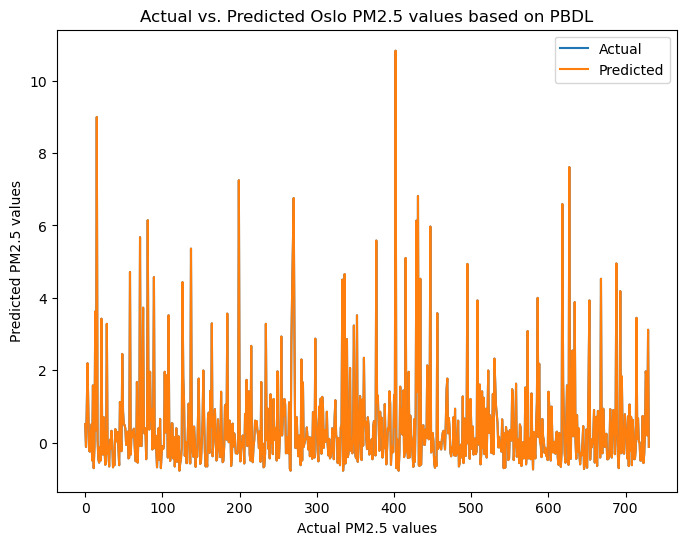

In [13]:
# Make predictions on the validation set

y_pred = model.predict(X_val)


# Plot predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.plot(y_val, label='Actual')
plt.plot(y_val, label='Predicted')
plt.xlabel('Actual PM2.5 values')
plt.ylabel('Predicted PM2.5 values')
plt.title('Actual vs. Predicted Oslo PM2.5 values based on PBDL')
plt.legend()
plt.show()


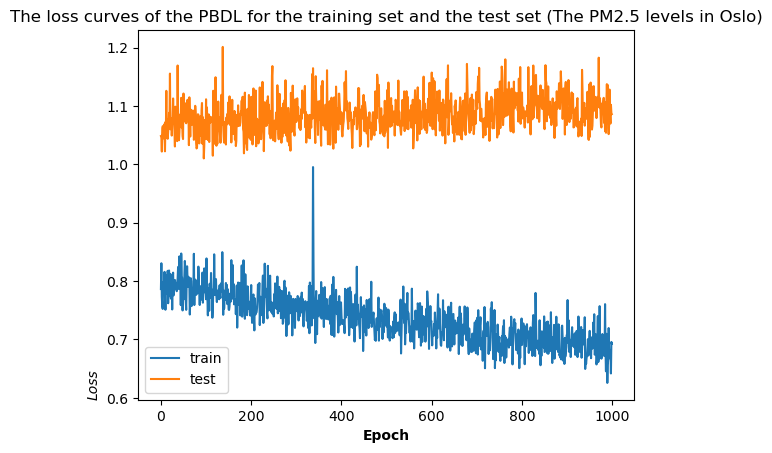

In [14]:
# 对损失进行可视化
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('The loss curves of the PBDL for the training set and the test set (The PM2.5 levels in Oslo)')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', style='italic', loc='bottom')
plt.legend()
plt.show()



